In [1]:
# Training NN with Elegy then do HMC with Oryx on Mana
# Author: Peter Oct 24 2021
# Requirements: 
#!module load system/CUDA/11.0.2 
#!pip install --upgrade jax jaxlib==0.1.68+cuda110 -f https://storage.googleapis.com/jax-releases/jax_releases.html 
#!pip install tensorflow-io oryx elegy

from collections import defaultdict
import numpy as np

import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set(style='whitegrid')

import os
#os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
#os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.10'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import jax
import jax.numpy as jnp
from jax import random
from jax import vmap
from jax import jit
from jax import grad
assert jax.default_backend() == 'gpu'

import elegy # pip install elegy
import optax
#import flax.linen
import tensorflow_io as tfio # pip install tensorflow-io
import tensorflow as tf # Recommended not to import this with jax because will also try to grab memory.

# Train and save NN model.

In [ ]:
# Define dataset
f = '/mnt/lts/nfs_fs02/sadow_lab/shared/gcr/data/proposal/data_processed.hdf5'
x = tfio.IODataset.from_hdf5(f, dataset='/X_minmax')
y = tfio.IODataset.from_hdf5(f, dataset='/Y_logp1_scaled')
full = tf.data.Dataset.zip((x, y))
# Split
train = full.take(np.floor(1435308 *.9)).repeat()
test = full.skip(np.floor(1435308 *.9)).repeat()
# Augment to help smooth out function.
# def add_gaussian_noise(x, y):
#     # x must be scaled in [0, 1]
#     with tf.name_scope('Add_gaussian_noise'):
#         noise = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=.1, dtype=tf.float32)
#         noise_x = x + noise
#         noise_x = tf.clip_by_value(noise_x, 0.0, 1.0)
#     return noise_x, y
# train = train.map(add_gaussian_noise)
# Batch
BATCH_SIZE = 128
train = train.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
test = test.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

class MLP(elegy.Module):
    def call(self, x: jnp.ndarray) -> jnp.ndarray:
        #initializer = elegy.initializers.RandomNormal(stddev=.001)
        initializer = None #elegy.initializers.TruncatedNormal()
        x = elegy.nn.Linear(256, w_init=initializer, b_init=initializer)(x)
        x = jax.nn.selu(x)
        #x = elegy.nn.Dropout(0.5)(x)
        
        x = elegy.nn.Linear(256, w_init=initializer, b_init=initializer)(x)
        x = jax.nn.selu(x)
        #x = elegy.nn.Dropout(0.3)(x)
        
        x = elegy.nn.Linear(245, w_init=initializer, b_init=initializer)(x)
        return x

model = elegy.Model(
    # Creates stateful model and optimizer. See elegy docs.
    module=MLP(),
    loss=[elegy.losses.MeanSquaredError(),
          #elegy.losses.MeanAbsoluteError(),
          #elegy.regularizers.GlobalL2(l=1e-4),
         ],
    #loss=[elegy.losses.MeanSquaredError(), elegy.regularizers.GlobalL2(l=1e-5)]
    #metrics=elegy.metrics.BinaryAccuracy(),
    optimizer=optax.adam(1e-4), 
    #optimizer=optax.sgd(1e-10),
    #optimizer=optimizers.rmsprop(1e-3), # Oryx based on optax. Doesn't work with elegy.
    #run_eagerly=True, # Seems to be necessary for 
)
path = 'model_2_256_selu'
callbacks = [elegy.callbacks.EarlyStopping(monitor="val_mean_squared_error_loss", patience=5),
             elegy.callbacks.ModelCheckpoint(path=path, save_best_only=True, monitor='val_mean_squared_error_loss'),
             #elegy.callbacks.TensorBoard("summaries"),
            ]

history = model.fit(
    x=train,
    epochs=50,
    steps_per_epoch=10000, #10000, # 10k*128 is approximate size of training set.
    validation_data=test,
    validation_steps=1000,
    shuffle=False,
    verbose=2,
    callbacks=callbacks,
)

# Save model. 
#model.save('model')  # creates folder at 'my_model'
#del model  # deletes the existing model
# Test ability to make prediction.
x = np.random.rand((7))
model.predict(x).shape

2021-11-16 01:10:52.542859: W tensorflow_io/core/kernels/audio_video_mp3_kernels.cc:271] libmp3lame.so.0 or lame functions are not available


# Attempt 2. try to be smoother.

In [3]:
# Define dataset
f = '/mnt/lts/nfs_fs02/sadow_lab/shared/gcr/data/proposal/data_processed.hdf5'
x = tfio.IODataset.from_hdf5(f, dataset='/X_minmax')
y = tfio.IODataset.from_hdf5(f, dataset='/Y_logp1_scaled')
full = tf.data.Dataset.zip((x, y))
# Split
train = full.take(np.floor(1435308 *.9)).repeat()
test = full.skip(np.floor(1435308 *.9)).repeat()
# Augment to help smooth out function.
# def add_gaussian_noise(x, y):
#     # x must be scaled in [0, 1]
#     with tf.name_scope('Add_gaussian_noise'):
#         noise = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=.1, dtype=tf.float32)
#         noise_x = x + noise
#         noise_x = tf.clip_by_value(noise_x, 0.0, 1.0)
#     return noise_x, y
# train = train.map(add_gaussian_noise)
# Batch
BATCH_SIZE = 128
train = train.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
test = test.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

class MLP(elegy.Module):
    def call(self, x: jnp.ndarray) -> jnp.ndarray:
        #initializer = elegy.initializers.RandomNormal(stddev=.001)
        initializer = None #elegy.initializers.TruncatedNormal()
        x = elegy.nn.Linear(256, w_init=initializer, b_init=initializer)(x)
        x = jax.nn.selu(x)
        #x = elegy.nn.Dropout(0.5)(x)
        
        x = elegy.nn.Linear(256, w_init=initializer, b_init=initializer)(x)
        x = jax.nn.selu(x)
        #x = elegy.nn.Dropout(0.3)(x)
        
        x = elegy.nn.Linear(245, w_init=initializer, b_init=initializer)(x)
        return x

model = elegy.Model(
    # Creates stateful model and optimizer. See elegy docs.
    module=MLP(),
    loss=[elegy.losses.MeanSquaredError(),
          #elegy.losses.MeanAbsoluteError(),
          elegy.regularizers.GlobalL2(l=1e-6),
         ],
    #loss=[elegy.losses.MeanSquaredError(), elegy.regularizers.GlobalL2(l=1e-5)]
    #metrics=elegy.metrics.BinaryAccuracy(),
    optimizer=optax.adam(1e-4), 
    #optimizer=optax.sgd(1e-10),
    #optimizer=optimizers.rmsprop(1e-3), # Oryx based on optax. Doesn't work with elegy.
    #run_eagerly=True, # Seems to be necessary for 
)
path = 'model_2_256_selu_l21e-6'
callbacks = [elegy.callbacks.EarlyStopping(monitor="val_mean_squared_error_loss", patience=5),
             elegy.callbacks.ModelCheckpoint(path=path, save_best_only=True, monitor='val_mean_squared_error_loss'),
             #elegy.callbacks.TensorBoard("summaries"),
            ]

history = model.fit(
    x=train,
    epochs=50,
    steps_per_epoch=10000, #10000, # 10k*128 is approximate size of training set.
    validation_data=test,
    validation_steps=1000,
    shuffle=False,
    verbose=2,
    callbacks=callbacks,
)

# Save model. 
#model.save('model')  # creates folder at 'my_model'
#del model  # deletes the existing model
# Test ability to make prediction.
x = np.random.rand((7))
model.predict(x).shape

Epoch 1/50
10000/10000 - 32s - l2_regularization_loss: 5.6000e-04 - loss: 0.0092 - mean_squared_error_loss: 0.0086 - val_l2_regularization_loss: 4.0906e-04 - val_loss: 4.3450e-04 - val_mean_squared_error_loss: 2.5448e-05
Epoch 2/50
10000/10000 - 16s - l2_regularization_loss: 2.8204e-04 - loss: 2.9406e-04 - mean_squared_error_loss: 1.2021e-05 - val_l2_regularization_loss: 1.7975e-04 - val_loss: 1.8655e-04 - val_mean_squared_error_loss: 6.7999e-06
Epoch 3/50
10000/10000 - 16s - l2_regularization_loss: 1.2187e-04 - loss: 1.2735e-04 - mean_squared_error_loss: 5.4803e-06 - val_l2_regularization_loss: 7.8663e-05 - val_loss: 8.3152e-05 - val_mean_squared_error_loss: 4.4884e-06
Epoch 4/50
10000/10000 - 16s - l2_regularization_loss: 5.5707e-05 - loss: 6.0090e-05 - mean_squared_error_loss: 4.3834e-06 - val_l2_regularization_loss: 3.9462e-05 - val_loss: 4.4400e-05 - val_mean_squared_error_loss: 4.9376e-06
Epoch 5/50
10000/10000 - 14s - l2_regularization_loss: 3.1409e-05 - loss: 3.5476e-05 - mean_

(245,)

In [2]:
%%time

# Make predictions on test set for analysis. 
# Define dataset
f = '/mnt/lts/nfs_fs02/sadow_lab/shared/gcr/data/proposal/data_processed.hdf5'
x = tfio.IODataset.from_hdf5(f, dataset='/X_minmax')
y = tfio.IODataset.from_hdf5(f, dataset='/Y_logp1_scaled')
full = tf.data.Dataset.zip((x, y))
# Split
train = full.take(np.floor(10000))
test = full.skip(np.floor(1435308 *.9)).take(np.floor(10000))
# Batch
BATCH_SIZE = 1000
train = train.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
test = test.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
# Load Model
model_path = 'model_2_256_selu_l21e-6'
model = elegy.load(model_path)
model.run_eagerly = True # Settable attribute. Required to be true for ppmodel.

# Train set
xs, ys, yhats = [], [], []
for i,(xbatch, ybatch) in enumerate(train.as_numpy_iterator()):
    #x, y =  x.numpy(), y.numpy()
    yhat = model.predict(xbatch)
    yhats.append(yhat)
    xs.append(xbatch)
    ys.append(ybatch)
xs = np.concatenate(xs, axis=0)
ys = np.concatenate(ys, axis=0)
yhats = np.concatenate(yhats)
assert ys.shape == yhats.shape
assert xs.shape[0] == yhats.shape[0]
np.savetxt(fname=f'train_inputs_10k.csv', X=xs, fmt='%.8e')
np.savetxt(fname=f'train_targets_10k.csv', X=ys, fmt='%.8e')
np.savetxt(fname=f'train_predictions_10k.csv', X=yhats, fmt='%.8e')

# Test set
xs, ys, yhats = [], [], []
for i,(xbatch, ybatch) in enumerate(test.as_numpy_iterator()):
    #x, y =  x.numpy(), y.numpy()
    yhat = model.predict(xbatch)
    yhats.append(yhat)
    xs.append(xbatch)
    ys.append(ybatch)
xs = np.concatenate(xs, axis=0)
ys = np.concatenate(ys, axis=0)
yhats = np.concatenate(yhats)
assert ys.shape == yhats.shape
assert xs.shape[0] == yhats.shape[0]

np.savetxt(fname=f'test_inputs_10k.csv', X=xs, fmt='%.8e')
np.savetxt(fname=f'test_targets_10k.csv', X=ys, fmt='%.8e')
np.savetxt(fname=f'test_predictions_10k.csv', X=yhats, fmt='%.8e')


2021-11-18 13:08:11.430107: W tensorflow_io/core/kernels/audio_video_mp3_kernels.cc:271] libmp3lame.so.0 or lame functions are not available
2021-11-18 13:08:12.336124: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


CPU times: user 14.2 s, sys: 3.28 s, total: 17.5 s
Wall time: 27.7 s


In [20]:
xs, yhats = [], []
for i in range(1):
    #x, y =  x.numpy(), y.numpy()
    xbatch = np.random.rand(2000, 7)
    yhat = model.predict(xbatch)
    yhats.append(yhat)
    xs.append(xbatch)
yhats = np.concatenate(yhats)
xs = np.concatenate(xs, axis=0)

np.savetxt(fname=f'random_uniform_X.csv', X=xs, fmt='%.8e')
np.savetxt(fname=f'random_uniform_Yhat.csv', X=yhats, fmt='%.8e')

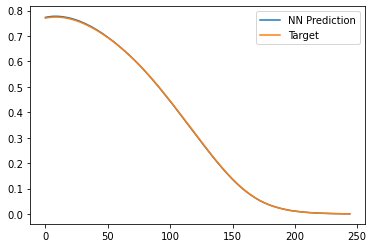

In [43]:

plt.plot(yhats[0,:], label='NN Prediction')
plt.plot(ys[0,:], label='Target')
plt.legend()

# Attempt 3

In [4]:
# Define dataset
f = '/mnt/lts/nfs_fs02/sadow_lab/shared/gcr/data/proposal/data_processed.hdf5'
x = tfio.IODataset.from_hdf5(f, dataset='/X_minmax')
y = tfio.IODataset.from_hdf5(f, dataset='/Y_logp1_scaled')
full = tf.data.Dataset.zip((x, y))
# Split
train = full.take(np.floor(1435308 *.9)).repeat()
test = full.skip(np.floor(1435308 *.9)).repeat()
# Augment to help smooth out function.
# def add_gaussian_noise(x, y):
#     # x must be scaled in [0, 1]
#     with tf.name_scope('Add_gaussian_noise'):
#         noise = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=.1, dtype=tf.float32)
#         noise_x = x + noise
#         noise_x = tf.clip_by_value(noise_x, 0.0, 1.0)
#     return noise_x, y
# train = train.map(add_gaussian_noise)
# Batch
BATCH_SIZE = 128
train = train.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
test = test.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

class MLP(elegy.Module):
    def call(self, x: jnp.ndarray) -> jnp.ndarray:
        #initializer = elegy.initializers.RandomNormal(stddev=.001)
        initializer = None #elegy.initializers.TruncatedNormal()
        x = elegy.nn.Linear(1024, w_init=initializer, b_init=initializer)(x)
        x = jax.nn.selu(x)
        x = elegy.nn.Dropout(0.5)(x)
        
        x = elegy.nn.Linear(1024, w_init=initializer, b_init=initializer)(x)
        x = jax.nn.selu(x)
        x = elegy.nn.Dropout(0.2)(x)
        
        x = elegy.nn.Linear(245, w_init=initializer, b_init=initializer)(x)
        return x

model = elegy.Model(
    # Creates stateful model and optimizer. See elegy docs.
    module=MLP(),
    loss=[elegy.losses.MeanSquaredError(),
          #elegy.losses.MeanAbsoluteError(),
          elegy.regularizers.GlobalL2(l=1e-6),
         ],
    #loss=[elegy.losses.MeanSquaredError(), elegy.regularizers.GlobalL2(l=1e-5)]
    #metrics=elegy.metrics.BinaryAccuracy(),
    optimizer=optax.adam(1e-4), 
    #optimizer=optax.sgd(1e-10),
    #optimizer=optimizers.rmsprop(1e-3), # Oryx based on optax. Doesn't work with elegy.
    #run_eagerly=True, # Seems to be necessary for 
)
path = 'model_2_256_selu_l21e-6_do'
callbacks = [elegy.callbacks.EarlyStopping(monitor="val_mean_squared_error_loss", patience=5),
             elegy.callbacks.ModelCheckpoint(path=path, save_best_only=True, monitor='val_mean_squared_error_loss'),
             #elegy.callbacks.TensorBoard("summaries"),
            ]

history = model.fit(
    x=train,
    epochs=50,
    steps_per_epoch=10000, #10000, # 10k*128 is approximate size of training set.
    validation_data=test,
    validation_steps=1000,
    shuffle=False,
    verbose=2,
    callbacks=callbacks,
)

# Save model. 
#model.save('model')  # creates folder at 'my_model'
#del model  # deletes the existing model
# Test ability to make prediction.
x = np.random.rand((7))
model.predict(x).shape

Epoch 1/50
10000/10000 - 35s - l2_regularization_loss: 0.0014 - loss: 0.0486 - mean_squared_error_loss: 0.0473 - val_l2_regularization_loss: 7.7867e-04 - val_loss: 8.1515e-04 - val_mean_squared_error_loss: 3.6481e-05
Epoch 2/50
10000/10000 - 16s - l2_regularization_loss: 3.6103e-04 - loss: 4.5157e-04 - mean_squared_error_loss: 9.0536e-05 - val_l2_regularization_loss: 9.0941e-05 - val_loss: 1.0680e-04 - val_mean_squared_error_loss: 1.5855e-05
Epoch 3/50
10000/10000 - 15s - l2_regularization_loss: 4.6915e-05 - loss: 9.8100e-05 - mean_squared_error_loss: 5.1186e-05 - val_l2_regularization_loss: 3.0342e-05 - val_loss: 4.1476e-05 - val_mean_squared_error_loss: 1.1133e-05
Epoch 4/50
10000/10000 - 15s - l2_regularization_loss: 2.6605e-05 - loss: 6.8386e-05 - mean_squared_error_loss: 4.1780e-05 - val_l2_regularization_loss: 2.4591e-05 - val_loss: 3.4421e-05 - val_mean_squared_error_loss: 9.8307e-06
Epoch 5/50
10000/10000 - 17s - l2_regularization_loss: 2.4137e-05 - loss: 6.1637e-05 - mean_squa

(245,)

# Attempt 4: 

In [ ]:
# Define dataset
f = '/mnt/lts/nfs_fs02/sadow_lab/shared/gcr/data/proposal/data_processed.hdf5'
x = tfio.IODataset.from_hdf5(f, dataset='/X_minmax')
y = tfio.IODataset.from_hdf5(f, dataset='/Y_logp1_scaled')
full = tf.data.Dataset.zip((x, y))
# Split
train = full.take(np.floor(1435308 *.9)).repeat()
test = full.skip(np.floor(1435308 *.9)).repeat()
# Augment to help smooth out function.
def add_gaussian_noise(x, y):
    # x must be scaled in [0, 1]
    with tf.name_scope('Add_gaussian_noise'):
        noise = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=.1, dtype=tf.float32)
        noise_x = x + noise
        noise_x = tf.clip_by_value(noise_x, 0.0, 1.0)
    return noise_x, y
train = train.map(add_gaussian_noise)
# Batch
BATCH_SIZE = 128
train = train.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
test = test.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

class MLP(elegy.Module):
    def call(self, x: jnp.ndarray) -> jnp.ndarray:
        #initializer = elegy.initializers.RandomNormal(stddev=.001)
        initializer = None #elegy.initializers.TruncatedNormal()
        x = elegy.nn.Linear(2048, w_init=initializer, b_init=initializer)(x)
        x = jax.nn.selu(x)
        x = elegy.nn.Dropout(0.5)(x)
        
        x = elegy.nn.Linear(2048, w_init=initializer, b_init=initializer)(x)
        x = jax.nn.selu(x)
        x = elegy.nn.Dropout(0.2)(x)
        
        x = elegy.nn.Linear(245, w_init=initializer, b_init=initializer)(x)
        return x

model = elegy.Model(
    # Creates stateful model and optimizer. See elegy docs.
    module=MLP(),
    loss=[elegy.losses.MeanSquaredError(),
          #elegy.losses.MeanAbsoluteError(),
          elegy.regularizers.GlobalL2(l=1e-6),
         ],
    #loss=[elegy.losses.MeanSquaredError(), elegy.regularizers.GlobalL2(l=1e-5)]
    #metrics=elegy.metrics.BinaryAccuracy(),
    optimizer=optax.adam(1e-4), 
    #optimizer=optax.sgd(1e-10),
    #optimizer=optimizers.rmsprop(1e-3), # Oryx based on optax. Doesn't work with elegy.
    #run_eagerly=True, # Seems to be necessary for 
)
path = 'model_2_256_selu_l21e-6_do_aug'
callbacks = [elegy.callbacks.EarlyStopping(monitor="val_mean_squared_error_loss", patience=5),
             elegy.callbacks.ModelCheckpoint(path=path, save_best_only=True, monitor='val_mean_squared_error_loss'),
             #elegy.callbacks.TensorBoard("summaries"),
            ]

history = model.fit(
    x=train,
    epochs=50,
    steps_per_epoch=10000, #10000, # 10k*128 is approximate size of training set.
    validation_data=test,
    validation_steps=1000,
    shuffle=False,
    verbose=2,
    callbacks=callbacks,
)

# Save model. 
#model.save('model')  # creates folder at 'my_model'
#del model  # deletes the existing model
# Test ability to make prediction.
x = np.random.rand((7))
model.predict(x).shape

Epoch 1/50
10000/10000 - 92s - l2_regularization_loss: 0.0027 - loss: 0.0461 - mean_squared_error_loss: 0.0434 - val_l2_regularization_loss: 0.0015 - val_loss: 0.0016 - val_mean_squared_error_loss: 6.8449e-05
Epoch 2/50
10000/10000 - 87s - l2_regularization_loss: 7.3936e-04 - loss: 9.3048e-04 - mean_squared_error_loss: 1.9112e-04 - val_l2_regularization_loss: 2.5369e-04 - val_loss: 2.7350e-04 - val_mean_squared_error_loss: 1.9814e-05
Epoch 3/50
10000/10000 - 84s - l2_regularization_loss: 1.2334e-04 - loss: 2.5761e-04 - mean_squared_error_loss: 1.3427e-04 - val_l2_regularization_loss: 6.1770e-05 - val_loss: 8.3680e-05 - val_mean_squared_error_loss: 2.1910e-05
Epoch 4/50
10000/10000 - 87s - l2_regularization_loss: 4.4561e-05 - loss: 1.6480e-04 - mean_squared_error_loss: 1.2024e-04 - val_l2_regularization_loss: 3.3528e-05 - val_loss: 5.6325e-05 - val_mean_squared_error_loss: 2.2796e-05
Epoch 5/50
10000/10000 - 78s - l2_regularization_loss: 2.8716e-05 - loss: 1.4204e-04 - mean_squared_erro

(245,)

# Attempt 5: 

In [6]:
# Define dataset
f = '/mnt/lts/nfs_fs02/sadow_lab/shared/gcr/data/proposal/data_processed.hdf5'
x = tfio.IODataset.from_hdf5(f, dataset='/X_minmax')
y = tfio.IODataset.from_hdf5(f, dataset='/Y_logp1_scaled')
full = tf.data.Dataset.zip((x, y))
# Split
train = full.take(np.floor(1435308 *.9)).repeat()
test = full.skip(np.floor(1435308 *.9)).repeat()
# Augment to help smooth out function.
def add_gaussian_noise(x, y):
    # x must be scaled in [0, 1]
    with tf.name_scope('Add_gaussian_noise'):
        noise = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=.1, dtype=tf.float32)
        noise_x = x + noise
        noise_x = tf.clip_by_value(noise_x, 0.0, 1.0)
    return noise_x, y
train = train.map(add_gaussian_noise)
# Batch
BATCH_SIZE = 128
train = train.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
test = test.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

class MLP(elegy.Module):
    def call(self, x: jnp.ndarray) -> jnp.ndarray:
        #initializer = elegy.initializers.RandomNormal(stddev=.001)
        initializer = None #elegy.initializers.TruncatedNormal()
        x = elegy.nn.Linear(2048, w_init=initializer, b_init=initializer)(x)
        x = jax.nn.selu(x)
        x = elegy.nn.Dropout(0.5)(x)
        
        x = elegy.nn.Linear(2048, w_init=initializer, b_init=initializer)(x)
        x = jax.nn.selu(x)
        x = elegy.nn.Dropout(0.2)(x)
        
        x = elegy.nn.Linear(2048, w_init=initializer, b_init=initializer)(x)
        x = jax.nn.selu(x)
        x = elegy.nn.Dropout(0.1)(x)
        
        x = elegy.nn.Linear(245, w_init=initializer, b_init=initializer)(x)
        return x

model = elegy.Model(
    # Creates stateful model and optimizer. See elegy docs.
    module=MLP(),
    loss=[elegy.losses.MeanSquaredError(),
          #elegy.losses.MeanAbsoluteError(),
          elegy.regularizers.GlobalL2(l=1e-6),
         ],
    #loss=[elegy.losses.MeanSquaredError(), elegy.regularizers.GlobalL2(l=1e-5)]
    #metrics=elegy.metrics.BinaryAccuracy(),
    optimizer=optax.adam(1e-4), 
    #optimizer=optax.sgd(1e-10),
    #optimizer=optimizers.rmsprop(1e-3), # Oryx based on optax. Doesn't work with elegy.
    #run_eagerly=True, # Seems to be necessary for 
)
path = 'model_3_2048_selu_l21e-6_do_aug'
callbacks = [elegy.callbacks.EarlyStopping(monitor="val_mean_squared_error_loss", patience=10),
             elegy.callbacks.ModelCheckpoint(path=path, save_best_only=True, monitor='val_mean_squared_error_loss'),
             #elegy.callbacks.TensorBoard("summaries"),
            ]

history = model.fit(
    x=train,
    epochs=50,
    steps_per_epoch=10000, #10000, # 10k*128 is approximate size of training set.
    validation_data=test,
    validation_steps=1000,
    shuffle=False,
    verbose=2,
    callbacks=callbacks,
)

# Save model. 
#model.save('model')  # creates folder at 'my_model'
#del model  # deletes the existing model
# Test ability to make prediction.
x = np.random.rand((7))
model.predict(x).shape

IndentationError: unexpected indent (3064977287.py, line 35)